<a href="https://colab.research.google.com/github/bikash119/bikash119/blob/main/learn_pytorch_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ViT paper implementation steps

In [1]:
## Calculate the patch embeddings input and output shape
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size= 16 # P

## Calculate N ( number of patches)
number_of_patches = int((height * width) / (patch_size**2))
print(f"Number of patches (N) with image height (H={height}, width={width}) and patch size (P =  {patch_size}) : {number_of_patches}")

Number of patches (N) with image height (H=224, width=224) and patch size (P =  16) : 196


### As mentioned in section 3.1 of ViT paper, the image of shape ( H, W,C ) will have to be converted to shape (number_of_patches, patch_size**2 * C)

In [2]:
## Input Shape ( Shape of single image)
embedding_layer_input_shape = (height, width, color_channels)
## Output Shape
embedding_layer_output_shape = (number_of_patches, patch_size**2*color_channels)

print(f'Input shape (single 2D image) : {embedding_layer_input_shape}')
print(f'Output shape (single 2D image flattened into patches) : {embedding_layer_output_shape}')

Input shape (single 2D image) : (224, 224, 3)
Output shape (single 2D image flattened into patches) : (196, 768)


## Download the data

In [3]:
import os
import zipfile

from pathlib import Path
import requests

def download_data(source:str,
                  destination:str,
                  remove_zip:bool=False) -> Path:
  """
    Downloads a zipped dataset and unzips it at destination

    Args:
      source(string): A link to zipped dataset
      destination(string): A target directory to unizp the downloaded zip file
      remove_zip(boolean): Whether to remove the source zip file after extracting.

    Returns:
      pathlib.Path to downloaded data.

    Example_Usage :
      download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                    destination="pizza_steak_sushi")
  """

  data_path = Path('data/')
  img_path = data_path / destination

  if img_path.is_dir():
    print(f"[INFO] {img_path} exists. Skipping download.")
  else:
    print(f"[INFO] Couldn't find {img_path} directory, creating one.")
    img_path.mkdir(parents=True,exist_ok=True)

    # Download data
    target_file = Path(source).name
    with open(data_path/target_file,"wb") as f:
      request = requests.get(source)
      f.write(request.content)

    #Unzip the downloaded data
    with zipfile.ZipFile(data_path/target_file,'r') as zipref:
      print(f"Unzipping {target_file} file to {destination}")
      zipref.extractall(img_path)

  if remove_zip:
    os.remove(data_path / target_file)

  return img_path


image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Couldn't find data/pizza_steak_sushi directory, creating one.
Unzipping pizza_steak_sushi.zip file to pizza_steak_sushi


PosixPath('data/pizza_steak_sushi')

In [4]:
try:
  from learn_pytorch.classification_src import data_setup, engine
except:
  !git clone https://github.com/bikash119/learn-pytorch.git learn_pytorch
  from learn_pytorch.classification_src import data_setup, engine

Cloning into 'learn_pytorch'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), 5.23 KiB | 1.74 MiB/s, done.


In [5]:
import torch
import torchvision
from torchvision import transforms
IMAGE_SIZE = 224 ## As mandated in the ViT paper
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create transforms
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, classes = data_setup.create_dataloader(train_dir=train_dir,
                                                                          test_dir=test_dir,
                                                                          train_transforms=manual_transforms,
                                                                          test_transforms=manual_transforms,
                                                                          batch_size=32)

train_dataloader, test_dataloader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7f5dc5657730>,
 ['pizza', 'steak', 'sushi'])

 Shape of single image :torch.Size([3, 224, 224])
 Label of the image : sushi


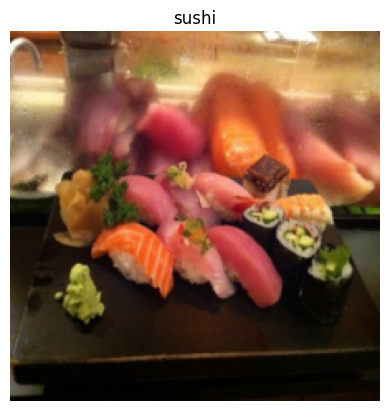

In [6]:
## Visualize the single image
image_batch,label_batch = next(iter(train_dataloader))
single_image, label = image_batch[0], label_batch[0]
print(f" Shape of single image :{single_image.shape}")
print(f" Label of the image : {classes[label]}" )
## Use matplotlib to display the image
import matplotlib.pyplot as plt

plt.imshow(single_image.permute(1,2,0))
plt.title(classes[label])
plt.axis(False);


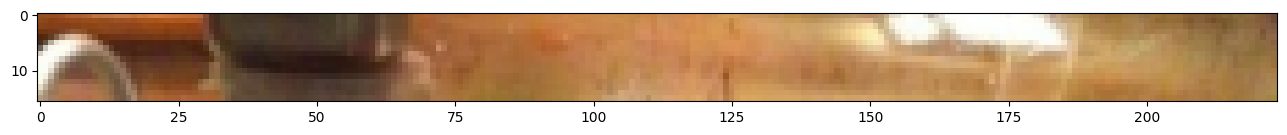

In [7]:
## Convert the image into patches
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(single_image.permute(1,2,0)[:patch_size,:,:]);

 Number of patches per row :14.0 
 Patch size: 16 pixels x 16 pixels


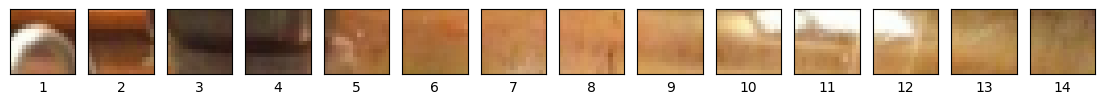

In [8]:
## Create patches out of the first row
## Setup hyperparameters and make sure `image_size` is compatible with `patch_size`
image_size=224
patch_size=16
permuted_image = single_image.permute(1,2,0)
num_patches= image_size/patch_size
assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
print(f" Number of patches per row :{ num_patches} \n Patch size: {patch_size} pixels x {patch_size} pixels")

#Create a series of subplots
fig,axs = plt.subplots(nrows=1,
                       ncols=image_size//patch_size,
                       figsize=(num_patches,num_patches),
                       sharex=True,
                       sharey=True)

for i,patch in enumerate(range(0,image_size,patch_size)):
  axs[i].imshow(permuted_image[:patch_size,patch:patch_size+patch,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])



 Number of patches per row :14.0 
 Patch size: 16 pixels x 16 pixels


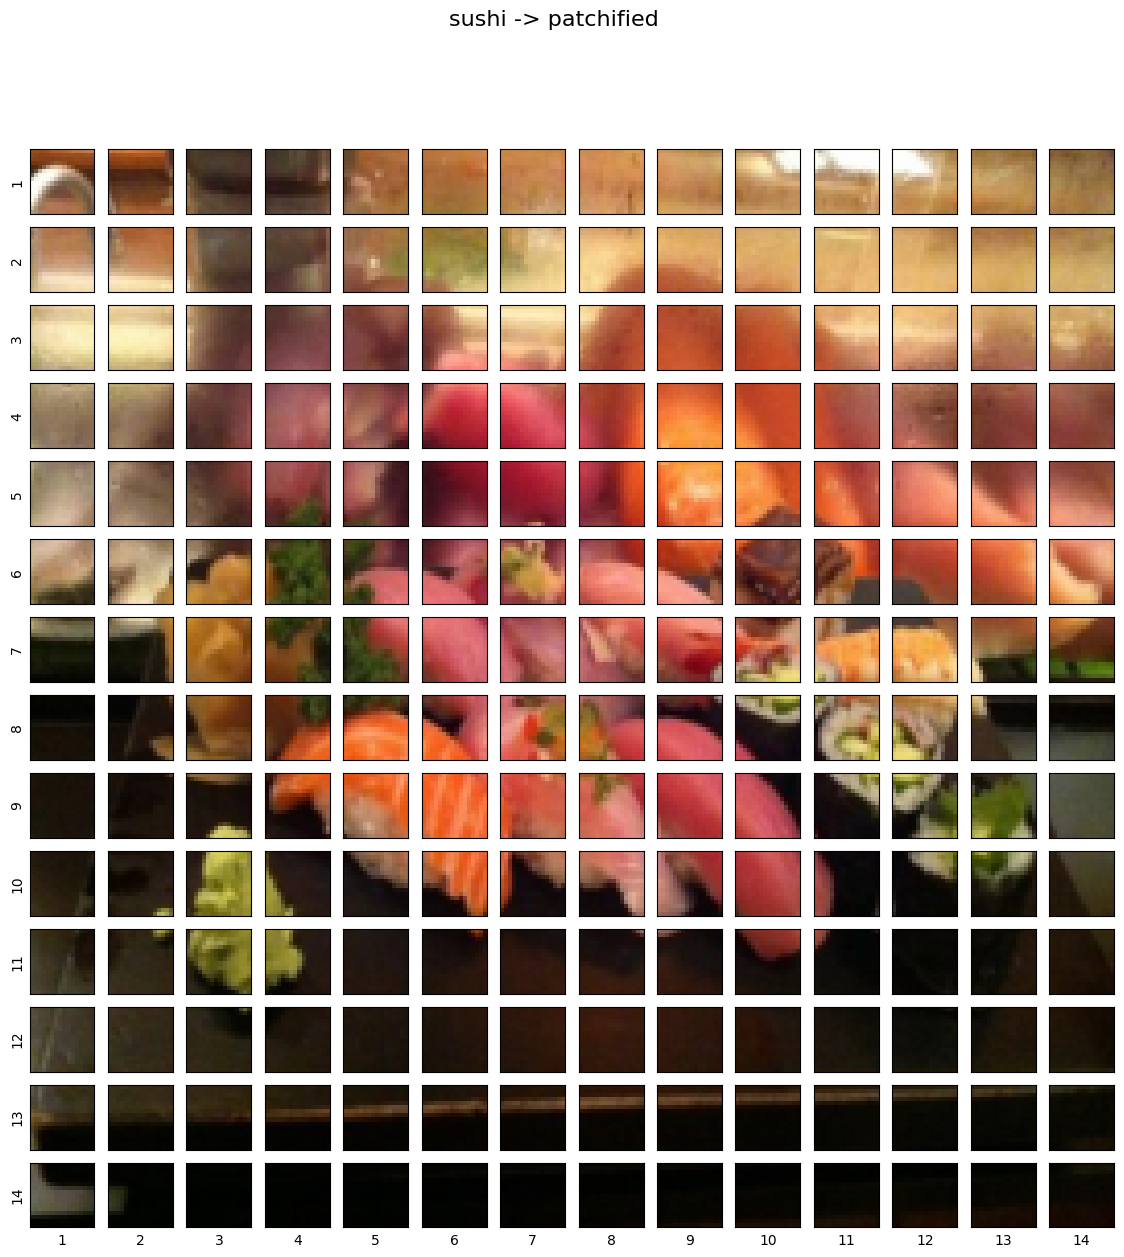

In [9]:
## Create patches for entire image
## Setup hyperparameters and make sure `image_size` is compatible with `patch_size`
image_size=224
patch_size=16
permuted_image = single_image.permute(1,2,0)
num_patches= image_size/patch_size
assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
print(f" Number of patches per row :{ num_patches} \n Patch size: {patch_size} pixels x {patch_size} pixels")

#Create a series of subplots
fig,axs = plt.subplots(nrows=image_size//patch_size,
                       ncols=image_size//patch_size,
                       figsize=(num_patches,num_patches),
                       sharex=True,
                       sharey=True)

for i,patch_height in enumerate(range(0,image_size,patch_size)):
  for j,patch_width in enumerate(range(0,image_size,patch_size)):
    axs[i,j].imshow(permuted_image[patch_height:patch_size+patch_height,
                                   patch_width:patch_size+patch_width,
                                   :])
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_ylabel(i+1)
    axs[i,j].set_yticks([])
    axs[i,j].set_xticks([])
    axs[i,j].label_outer()

fig.suptitle(f"{classes[label]} -> patchified",fontsize=16)
plt.show()

### Replicate the patch embedding layers with PyTorch
> **Hybrid Architecture**. As an alternative to raw image patches, the input sequence can be formed
from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding
projection E (Eq. 1) is applied to patches extracted from a **CNN feature map**. As a special case,
the patches can have spatial size 1x1, which means that the input sequence is obtained by simply
flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.
The classification input embedding and position embeddings are added as described above.

*The CNN feature map referred above are the weights/activations produced by convolutional layer passing over an image*

##### Re-create the creation of patches in pytorch by setting the `kernel_size` and `stride` equal to `patch_size` in `torch.nn.Conv2d`

In [10]:
from torch import nn

#Set the patch size
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

## image out of conv layer
conv_output = conv2d(single_image.unsqueeze(dim=0))
print(f"Shape of conv_output : {conv_output.shape} -> [batch_size,embedding_dim, feature_map_height,feature_map_width]")

Shape of conv_output : torch.Size([1, 768, 14, 14]) -> [batch_size,embedding_dim, feature_map_height,feature_map_width]


 Showing random convolutional feature maps from indexes :[260, 767, 62, 281, 515]


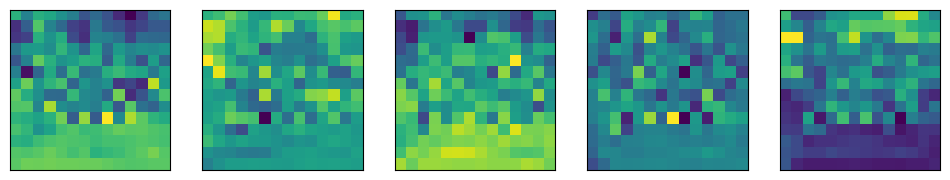

In [11]:
## Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0,786),k=5)

print(f" Showing random convolutional feature maps from indexes :{random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i, idx in enumerate(random_indexes):
  img_conf_feature_map=conv_output[:,idx,:,:]
  axs[i].imshow(img_conf_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[]);

In [12]:
!whoami

root


In [13]:
single_feature_map=conv_output[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[ 5.5362e-02,  1.9659e-03,  1.2381e-01,  7.9844e-02, -3.4090e-02,
            1.2795e-02,  2.2683e-02,  7.6552e-02,  5.8247e-02,  1.6872e-01,
            1.9728e-01,  9.3399e-02,  1.9717e-02,  6.2353e-02],
          [ 3.6936e-02,  9.4215e-02,  1.1778e-01, -2.7600e-03, -2.7239e-02,
            3.5349e-02,  1.6331e-01,  1.2091e-01,  5.9306e-03,  5.8293e-02,
            1.1754e-01,  7.1910e-02,  6.1240e-02,  4.7057e-02],
          [ 8.1422e-02,  7.1479e-02,  6.3642e-02, -1.2445e-03,  4.4782e-02,
            1.2552e-02,  1.6702e-01,  1.3418e-02, -6.0781e-02, -6.2538e-02,
            1.0072e-04,  3.4882e-02,  4.9111e-02,  4.2800e-02],
          [ 1.0881e-01,  8.8559e-02, -1.4685e-02, -1.8613e-02, -1.3050e-02,
           -6.0852e-02, -1.4571e-01, -3.9968e-02, -6.9578e-02, -5.4780e-02,
           -6.2242e-02,  3.1705e-02, -1.0537e-02, -2.2177e-02],
          [ 5.7320e-02,  9.2454e-02,  5.8887e-02, -4.7566e-02, -1.4052e-02,
           -6.3270e-02, -1.1733e-01, -5.4362e-02, -5.4683e-0

## Flattening the patch embedding with `torch.nn.Flatten()`
**Desired output (1D sequence of flattend 2D patches):** (196,768) -> (Number of patches, embedding dimension) -> N X (P<sup>2</sup>.C)

In [14]:
#current tensor shape
print(f" Current tensor shape : {conv_output.shape}")

 Current tensor shape : torch.Size([1, 768, 14, 14])


We have the P<sup>2</sup>.C piece from -> N X (P<sup>2</sup>.C).We can use the `nn.Flatten()` to flatten the _spatial feature map_ as mentioned in **Hybrid Architecture** section of ViT paper

In [15]:
flatten = nn.Flatten(start_dim=2,end_dim=3)

### Lets put everything together

1. Take a single image
2. Put it through the convolution layer `nn.Conv2d` to turn the image into 2D feature maps (patch embeddings)
3. Flatten the 2D feature maps to a single sequence





 Shape of original image : torch.Size([3, 224, 224])
 Shape of output of conv2d : torch.Size([1, 768, 14, 14])
 Shape of flattened output : torch.Size([1, 768, 196])


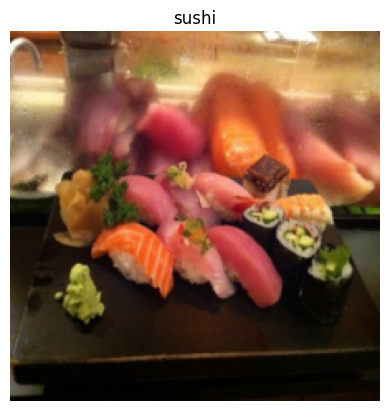

In [16]:
plt.imshow(single_image.permute(1,2,0))
plt.title(classes[label])
plt.axis(False);
print(f" Shape of original image : {single_image.shape}")

img_out_of_conv = conv2d(single_image.unsqueeze(dim=0))
print(f" Shape of output of conv2d : {img_out_of_conv.shape}")
flattened_image = flatten(img_out_of_conv)
print(f" Shape of flattened output : {flattened_image.shape}")

## Almost there
**Desired output** : (196, 768)

**Flattened output** : (1, 768, 196)

We can use `torch.Tensor.permute` to bring the output of `nn.Flatten()` to the desired output

In [17]:
conv_output_flattened_reshaped = flattened_image.permute(0,2,1)
print(f" Shape of the reshaped tensor after passing through conv2d and flatten : {conv_output_flattened_reshaped.shape} -> [ batch_size,number_of_patches,embedding_dim ]")

 Shape of the reshaped tensor after passing through conv2d and flatten : torch.Size([1, 196, 768]) -> [ batch_size,number_of_patches,embedding_dim ]


## Visualize a single feature map

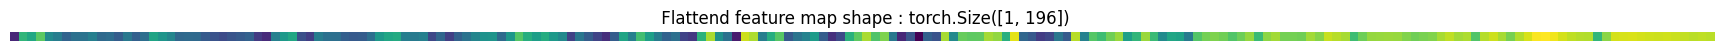

In [18]:
single_flattened_feature_map = conv_output_flattened_reshaped[:,:,1]

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f" Flattend feature map shape : {single_flattened_feature_map.shape}")
plt.axis(False);

### Turing the ViT patch embedding layer into a Pytorch module


1. Create a class called `PatchEmbedding` with subclasses `nn.Module`
2. Initialize the class with parameters `in_channels=3, patch_size=16 and embedding_dim=768`
3. Create a layer to turn images into patches using `nn.Conv2d`.
4. Flatten the output of step 3. using `nn.Flatten` and flatten only the _patch feature maps_ into a single dimension.
5. Define a `forward()` method to take the input and pass it through the layers created in Step 3. and Step 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture ( N X P<sup>2</sup>.C)



In [19]:
class PatchEmbedding(nn.Module):

  """
    Turns a 2D input image into a 1D sequence learnable embedding vector

    Args:
      in_channels(integer): Number of color channels for the input images. Defaults to 3
      patch_size(integer): Size of patches to convert the image into. Defults to 16
      embedding_dim(integer): Size of embedding to turn image into. Defaults to 768
  """
  def __init__(self, in_channels:int= 3,
               patch_size:int= 16,
               embedding_dim:int= 768):
    super().__init__()

    ## The layer to convert image to patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    ## The layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self,x):
    image_resolution=x.shape[-1]
    assert image_resolution % patch_size ==0 ,f"Input size must be divisible by patch_size, image_shape: {image_resolution}, patch_size:{patch_size}"

    # perform the forward pass
    x_patched = self.patcher(x)
    #print(f" Shape of patched image : {x_patched.shape}")
    x_flattend = self.flatten(x_patched)
    #print(f" Shape of flattend output : {x_flattend.shape}")
    return x_flattend.permute(0,2,1)



Lets try the `PatchEmbedding` on a single image

In [20]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f" Shape of single image : {single_image.shape}")
## Pass the image through patch embedding
patched_flattend_img = patchify(single_image.unsqueeze(dim=0))
print(f" Shape of image after going through PatchEmbedding: {patched_flattend_img.shape}")

 Shape of single image : torch.Size([3, 224, 224])
 Shape of image after going through PatchEmbedding: torch.Size([1, 196, 768])


In [21]:
## Lets get summary of our PatchEmbeddingLayer
random_input_image = (1,3,224,224)
random_input_image_error = (1, 3, 250,250)
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  import torchinfo
  from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
summary(PatchEmbedding(),input_size=random_input_image,
        col_names=["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]          [1, 196, 768]             --                        True
├─Conv2d (patcher)                       [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
├─Flatten (flatten)                      [1, 768, 14, 14]          [1, 768, 196]             --                        --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [23]:
summary(PatchEmbedding(),input_size=random_input_image_error,
        col_names=["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"])

RuntimeError: ignored

### Creating the class token embedding
### pseudocode
1. Create a learnable embedding of size `embedding_dim`
2. patch_embedding=[image_patch_1,image_patch_2,image_patch_3...., image_patch_n]
3. patch_embedding_with_class_token =  `torch.cat((class_token,patch_embedding),dim=1)`

To do so , we'll get batch_size and embedding dimension shape and then will create a `torch.ones()` in the the shape of `[batch_size,1,embedding_dim]`

In [24]:
# Get the batch_size and embedding_dim
batch_size = patched_flattend_img.shape[0]
embedding_dim = patched_flattend_img.shape[-1]

## Create the class token embedding as a learnable parameter that share the
## same size as the embedding dimension (D)
class_token = nn.Parameter(data=torch.ones(batch_size,1,embedding_dim),requires_grad=True)

## Print the first 10 examples of the class_token
print(class_token[:,:,:10])

## Print the class_token shape
print(f" class token shape : {class_token.shape} -> [batch_size,number_of_tokens,embedding_dim]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
 class token shape : torch.Size([1, 1, 768]) -> [batch_size,number_of_tokens,embedding_dim]


In [25]:
## Add the class token to the start of patch_embedding
class_token_with_patch_embedded_image = torch.cat((class_token,patched_flattend_img),dim=1)
print(class_token_with_patch_embedded_image);
print(f" Shape of Sequence of class token along with patch embedding :{class_token_with_patch_embedded_image.shape} -> [batch_size,number_of_patches,embedding_dim]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.1772, -0.3110,  0.1295,  ..., -0.1591,  0.2372,  0.0800],
         [ 0.0580, -0.1186,  0.0943,  ..., -0.2571,  0.1744,  0.0629],
         ...,
         [-0.0116,  0.0066, -0.0177,  ...,  0.0125,  0.0099,  0.0129],
         [-0.0019,  0.0049, -0.0192,  ...,  0.0062,  0.0178,  0.0136],
         [-0.0057,  0.0082, -0.0281,  ..., -0.0234,  0.0282,  0.0060]]],
       grad_fn=<CatBackward0>)
 Shape of Sequence of class token along with patch embedding :torch.Size([1, 197, 768]) -> [batch_size,number_of_patches,embedding_dim]


#### Creating the position embedding
We need to create _standard learnable 1D position embeddings_
So lets make a learnable 1D embedding with torch.ones() to create E<sub>pos</sub>

In [26]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / (patch_size**2))

## Get the embedding dimension
embedding_dimension = patched_flattend_img.shape[-1]

## Create the 1D learnable embedding
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                  requires_grad=True)

print(position_embedding[:,:10,:10])
print(f" Position embedding shape : {position_embedding.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
 Position embedding shape : torch.Size([1, 197, 768])


In [27]:
## Add the position_embedding to the patch_embedding and class_token embedding
patch_and_position_embedding = position_embedding + class_token_with_patch_embedded_image
print(patch_and_position_embedding)
print(f" Shape of Patch embeddings, class token prepended and positional embedding added : {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.1772, 0.6890, 1.1295,  ..., 0.8409, 1.2372, 1.0800],
         [1.0580, 0.8814, 1.0943,  ..., 0.7429, 1.1744, 1.0629],
         ...,
         [0.9884, 1.0066, 0.9823,  ..., 1.0125, 1.0099, 1.0129],
         [0.9981, 1.0049, 0.9808,  ..., 1.0062, 1.0178, 1.0136],
         [0.9943, 1.0082, 0.9719,  ..., 0.9766, 1.0282, 1.0060]]],
       grad_fn=<AddBackward0>)
 Shape of Patch embeddings, class token prepended and positional embedding added : torch.Size([1, 197, 768])


#### Putting it all together : From Image to embedding

In [28]:
## Set Seeds
def set_seed(seed:int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [29]:
single_image.shape

torch.Size([3, 224, 224])

In [30]:
## Set seed
set_seed()

print(f" Shape of single image :{single_image.shape}")
height, width = single_image.shape[1], single_image.shape[1]
color_channels = single_image.shape[0]

## Set hyperparameters from ViT paper
patch_size = 16
embedding_dim = 768
number_of_patches = int((height * width) / (patch_size**2))

assert height % patch_size == 0,f'Input size must be divisible by patch_size, image_shape: {height}, patch_size:{patch_size}'

## Get the image tensor and add batch dimension
x = single_image.unsqueeze(dim=0)
print(f" Shape of image tensor after addition of batch dimension : {x.shape}")
## Get Patch embedding
patchify = PatchEmbedding(in_channels=color_channels,
                          patch_size=patch_size,
                          embedding_dim=embedding_dim)
patch_embedding = patchify(x)

print(f" Shape of patch embedding : {patch_embedding.shape}")
batch_size = patch_embedding.shape[0]
## Create Class token
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim),
                          requires_grad=True)

print(f" Shape of class token : {class_token.shape}")
## Add class token
class_token_and_patch_embedding = torch.cat((class_token,patch_embedding),dim=1)

print(f" Shape of class token prepended to patch embedding : {class_token_and_patch_embedding.shape}")
## Create position embedding
position_embedding = nn.Parameter(torch.ones(batch_size,number_of_patches+1,embedding_dim),
                                   requires_grad=True)

print(f" Shape of position embedding : {position_embedding.shape}")
## Add position embedding to class_token_and_patch_embedding
position_embedding_added_to_patch_embedding = position_embedding + class_token_and_patch_embedding
print(f" Shape of outpupt of position embedding added to class token with patch embedding : {position_embedding_added_to_patch_embedding.shape}")

 Shape of single image :torch.Size([3, 224, 224])
 Shape of image tensor after addition of batch dimension : torch.Size([1, 3, 224, 224])
 Shape of patch embedding : torch.Size([1, 196, 768])
 Shape of class token : torch.Size([1, 1, 768])
 Shape of class token prepended to patch embedding : torch.Size([1, 197, 768])
 Shape of position embedding : torch.Size([1, 197, 768])
 Shape of outpupt of position embedding added to class token with patch embedding : torch.Size([1, 197, 768])


## Equation 2: Multi-Head Attention (MSA)


1. Multi-Head Self Attenion ( MSA ) - `torch.nn.MultiheadAttention`
2. Layer Normalization - `torch.nn.LayerNorm`
3. Residual Connection - Add the input to the output

Z<sup>'</sup><sub>l</sub> = MSA(LN(Z<sub>l-1</sub>))+Z<sub>l-1</sub>,    l=1...L



### Layer Normalization or Norm or LayerNorm normalizes an input over the last dimension
Layer Normalization improves training time and model generalization
More intutively : _getting data into similar distribution_

Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch,eventually forming a learned representation of image.

### Replicating Eq 2 using Pytorch Layers
1. Create a class called `MultiHeadSelfAttentionLayer` that inherits from `torch.nn.Module`
2. Initialize the class with hyperparameters mentioned in ViT paper
3. Create a Layer Normalization( LN ) layer with `torch.nn.LayerNorm`
4. Create a multi-head attention (MSA) layer with appropriate `embed_dim`, `num_heads`,`dropout`, `batch_first` parameters.

  embed_dim: the embedding dimenstion.
  num_heads: how many attention heads to use.
  dropout: whether or not to apply dropout to the attention layer.
  batch_first: does our batch dimension comes first?
5. Create a `forward()`method for our class passing in the inputs through the LayerNorm and MSA Layer.


In [31]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionLayer(nn.Module):
  # 2. Initialize the class with hyperparameters
  def __init__(self,embedding_dim:int,
               num_heads:int,
               attn_dropout:float=0,
               batch_first:bool=True):
    super().__init__()

    # 3. Create the Layer Norm(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # 4. Create multi-head attention layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=batch_first)

  # 5. Create forward() method to pass the data through the layers.
  def forward(self,x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)
    return attn_output

MSA Created

In [32]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionLayer(embedding_dim=768,num_heads=12)

# pass patched_embedding through multihead_self_attention_block
patched_image_through_msa_block = multihead_self_attention_block(position_embedding_added_to_patch_embedding)
print(f" Input to the MSA block : {position_embedding_added_to_patch_embedding.shape}")
print(f" Output from the MSA block : {patched_image_through_msa_block.shape}")

 Input to the MSA block : torch.Size([1, 197, 768])
 Output from the MSA block : torch.Size([1, 197, 768])


# Equation 3: Multilayer Perceptron(MLP)

Z<sub>l</sub>=MLP(LN(Z<sup>'</sup><sub>l</sub>)) + Z<sup>'</sup><sub>l</sub>    l= 1...L


The term **MLP** is quite broad as it can refer to almost any combination of multiple layers

> A Linear layer `nn.Linear()` can sometimes also be referred as a 'dense layer' or 'feed forward layer'.

Our structure of **MLP** block will be
`layer_norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout `

## Replicating Equation 3 with Pytorch layers

To do so , we will
1. Create a class called `MLPBlock` that inherits from `torch.nn.Module`
2. Initialize the class with hyperparameters from ViT paper
3. Create a layer normalization (LN) layer with `nn.LayerNorm()` with the `normalized_shape` parameter set to `embedding_dim` value.
4. Create a sequential series of MLP layer using `torch.nn.Linear()` and `torch.nn.Dropout` and `torch.nn.GELU` with appropriate hyperparameter values from ViT paper
5. Create a `forward()` method for our class passing the input through the Layer Normalization and MLP layer(s).

In [33]:
# 1. Create a class called MLPBlock that inherits from torch.nn.Module

class MLPBlock(nn.Module):
  # 2. Initialize te class with hyperparameters
  def __init__(self,
               embedding_dim:int,
               mlp_size:int,
               dropout:float=0.1):
    super().__init__()

    # 3. Create a layer normalization (LN) with
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # 4. Create a sequential series of MLP layer
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size,bias=True),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim,bias=True),
        nn.Dropout(p=dropout)
    )
    # 5. Create a forward() method to pass the data through the layers
  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

MLPBlock class created

In [34]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
# pass output of MSABlock through MLPBlock
patched_image_through_mlpblock = mlp_block(patched_image_through_msa_block)
print(f" Input shape to MLP block : {patched_image_through_msa_block.shape}")
print(f" Output shape to MLP block : {patched_image_through_mlpblock.shape}")

 Input shape to MLP block : torch.Size([1, 197, 768])
 Output shape to MLP block : torch.Size([1, 197, 768])


> In deep learning, and "encoder" or "auto encoder" generally refers to a stack of layers that "encodes" an input (turns input into some form of numerical representations).

One of the main ideas of skip connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and thus allow deeper representations to be learned.

## Creating a Transformer encoder by combining out custom layers


1. Create a class called `TransformerEncoderBlock` that inherits from `torch.nn.Module`
2. Initialize the class with hyperparameters
3. Instantiate a MSA Block for Eq 2 in ViT paper using `MultiheadSelfAttentionLayer` with appropriate parameters.
4. Intantiate a MLP Block for Eq 3 in ViT paper using `MLPBlock` with appropriate parameters.
5. Create a `forward()` method for our `TransformerEncoderBlock` class
6. Create a residual connection for the MSABlock
7. Create a residual connection for the MLPBlock



In [35]:
# 1. Create a class called TransformerEncoderBlock that inherits from torch.nn.Module
class TransformerEncoderBlock(nn.Module):
  # 2. Initialize the class with hyperparameters
  def __init__(self
               ,embedding_dim:int=768
               ,num_heads:int=12
               ,mlp_size:int=3072
               ,mlp_dropout:float=0.1
               ,attn_dropout:float=0):
    super().__init__()
    # 3. Instantiate a MSA Block
    self.msa_block = MultiheadSelfAttentionLayer( embedding_dim=embedding_dim
                                                 ,num_heads=num_heads
                                                 ,attn_dropout=attn_dropout)
    # 4. Intantiate a MLP Block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim
                              ,mlp_size=mlp_size
                              ,dropout=mlp_dropout)

  # 5. Create a forward() method for our TransformerEncoderBlock class
  def forward(self,x)-> torch.Tensor:
    # 6. Create a residual connection for the MSABlock
    x = self.msa_block(x) + x
    # 7. Create a residual connection for the MLPBlock
    x = self.mlp_block(x)+x
    return x


In [36]:
## Lets get the torchinfo.summary() output for our TransformerEncoderBlock by passing
## input of size (1, 197,769) -> [batch_size,num_patches,embedding_dim]

summary(model=TransformerEncoderBlock(),
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]             [1, 197, 768]             --                        True
├─MultiheadSelfAttentionLayer (msa_block)          [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention (multihead_attn)         --                        [1, 197, 768]             2,362,368                 True
├─MLPBlock (mlp_block)                             [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential (mlp)                            [1, 19

We can create the `TransformerEncoderBlock` by using `nn.TransformerEncoderLayer` from pytorch's library

In [38]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768
                                                             ,nhead=12
                                                             ,dim_feedforward=3072
                                                             ,dropout=0.1
                                                             ,activation='gelu'
                                                             ,batch_first=True
                                                             ,norm_first=True
                                                             )

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [40]:
summary(model=torch_transformer_encoder_layer
        ,input_size=(1,197,768)
        ,col_names=["input_size","output_size","num_params","trainable"]
        ,row_settings=["var_names"])

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]             [1, 197, 768]             7,087,872                 True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

### Our own implementation of ViT

1. Create a class called `ViT` inheriting from `nn.Module`
2. Initialize the class with hyperparameters mentioned in Table 1 for ViT paper for ViT-Base model.
3. Make sure image resolution is divisible by `patch_size`
4. Calculate the number of patches using the formulat _N = HW/P<sup>2</sup>_ where H is image height, W is image width and P is patch_size.
5. Create a learnable class embedding token.
6. Create a learnable position embedding vector.
7. Setup the embedding dropout layer.
8. Create the patch embedding layer using the `PatchEmbedding` class created above in the notebook
9. Create a series of Transformer Encoder block by passing a list of `TransfomerEncoderBlock` to `nn.Sequential()`
10. Create the MLPHead(also called classifier head) by passing a `torch.nn.LayerNorm` and `torch.nn.Linear(out_features=len(classes)` layer to `nn.Sequential()`
11. Create a `forward()` method that accepts an input
12. Get the batch size of the input.
13. Create the patch embedding using the layer created in step 8.
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches from step 12 using `torch.Tensor.Expand()`
15. Concatenate the class token embedding from step 14 to the first dimension of patch embedding created in step 13 using `torch.cat`
16. Add the position embedding created in Step 6 to the output of Step 14.
17. Pass the patch and position embedding from step 16 through the dropout layer created in Step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9.
19. Pass index 0 of the output of the stack of Transformer Encoder layers from Step 17 through the classifier head created in step 10.




In [51]:
from torch.nn.modules.linear import Linear
# 1. Create a class called ViT inheriting from nn.Module
class ViT(nn.Module):
  # 2. Initialize the class with hyperparameters mentioned in Table 1 for ViT paper for ViT-Base model.
  def __init__(self
               ,img_size:int=224
               ,in_channels:int=3
               ,patch_size:int=16
               ,num_transformer_layer:int=12
               ,embedding_dim:int=768
               ,mlp_size:int=3072
               ,num_heads:int=12
               ,attn_dropout:float=0
               ,mlp_dropout:float=0.1
               ,embedding_dropout:float=0.1
               ,num_classes:int=1000):
    super().__init__()
    # 3. Make sure image resolution is divisible by patch_size
    assert image_size % patch_size == 0, f" Image size {img_size} must be divisible by patch size {patch_size}"
    # 4. Calculate the number of patches using the formulat N = HW/P2 where H is image height, W is image width and P is patch_size.
    self.num_of_patches = (img_size**2) // (patch_size**2)
    # 5 Create a learnable class embedding token.
    self.class_embedding = nn.Parameter(data=torch.rand(1,1,embedding_dim)
                                        ,requires_grad=True)
    # 6. Create a learnable position embedding vector.
    self.position_embedding = nn.Parameter(data=torch.rand(1
                                                           ,self.num_of_patches+1
                                                           ,embedding_dim)
                                           ,requires_grad=True)
    # 7. Setup the embedding dropout layer.
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 8. Create the patch embedding layer using the PatchEmbedding class created above in the notebook
    self.patch_embedding = PatchEmbedding(in_channels=in_channels
                                          ,patch_size=patch_size
                                          ,embedding_dim=embedding_dim)

    # 9. Create a series of Transformer Encoder block by passing a list of TransfomerEncoderBlock to nn.Sequential()
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim
                                                                       ,num_heads=num_heads
                                                                       ,mlp_size=mlp_size
                                                                       ,mlp_dropout=mlp_dropout
                                                                       ,attn_dropout=attn_dropout) for _ in range(num_transformer_layer)])
    # 10. Create the MLPHead(also called classifier head) by passing a torch.nn.LayerNorm and torch.nn.Linear(out_features=len(classes) layer to nn.Sequential()
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim)
        ,nn.Linear(in_features=embedding_dim
                   ,out_features=num_classes)
    )
  # 11. Create a forward() method that accepts an input
  def forward(self,x) -> torch.Tensor:
    # 12 . Get the batch size of the input.
    batch_size = x.shape[0]
    # 13. Create the patch embedding using the layer created in step 8.
    x = self.patch_embedding(x)
    # 14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches from step 12 using torch.Tensor.Expand()
    class_token = self.class_embedding.expand(batch_size, -1, -1) #TODO : Learn more about this
    # 15. Concatenate the class token embedding from step 14 to the first dimension of patch embedding created in step 13 using torch.cat
    x = torch.cat((class_token,x),dim=1)
    # 16. Add the position embedding created in Step 6 to the output of Step 14.
    x = self.position_embedding + x
    # 17. Pass the patch and position embedding from step 16 through the dropout layer created in Step 7.
    x = self.embedding_dropout(x)
    # 18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9.
    x = self.transformer_encoder(x)
    # 19. Pass index 0 of the output of the stack of Transformer Encoder layers from Step 17 through the classifier head created in step 10.
    x = self.classifier(x[:,0])

    return x

### Let's pass a random tensor in the same shape as single image through the ViT class and observe the output

In [52]:
# Set the seeds
set_seed()

# Create a random tensor of the same shape as single image
random_img_tensor = torch.rand(size=(1,3,224,224))

# Create an instance of ViT with number of classes we are working with
vit = ViT(num_classes=len(classes))

# Pass the random tensor through ViT instance
vit(random_img_tensor)


tensor([[ 0.0396,  0.1050, -0.7432]], grad_fn=<AddmmBackward0>)

In [53]:
summary(vit
        ,input_size=(1,3,224,224)
        ,col_names=["input_size","output_size","num_params","trainable"]
        ,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                                    [1, 3, 224, 224]          [1, 3]                    152,064                   True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]          [1, 196, 768]             --                        True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]          [1, 768, 196]             --                        --
├─Dropout (embedding_dropout)                                [1, 197, 768]             [1, 197, 768]             --                        --
├─Sequential (transformer_encoder)                           [1, 197, 768]             [1, 197, 768]             --                    